### Binary Classification - Plant Disease Detection

In [1]:
import os                                   # importing library files for deep learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import cv2
import traceback
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import  save_model

In [2]:
data_dir = "color"                # providing directory name

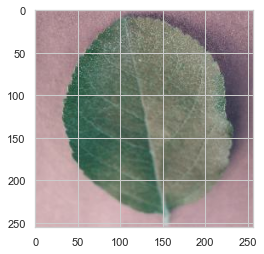

In [3]:
img = cv2.imread("C:/Users/Abhishek/Desktop/plant_disease/color/Apple___healthy/00a6039c-e425-4f7d-81b1-d6b0e668517e___RS_HL 7669.jpg")
plt.imshow(img)                     # visualisation of normal image

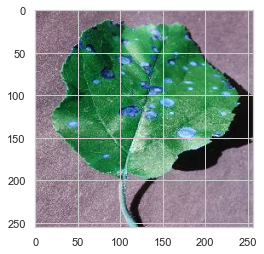

In [4]:
img = cv2.imread("C:/Users/Abhishek/Desktop/plant_disease/color/Apple___Black_rot/0bc40cc3-6a85-480e-a22f-967a866a56a1___JR_FrgE.S 2784.jpg")
plt.imshow(img)                 # visualisation of infected image

In [5]:
category_count = []                               # counting samples of images of each category

for root, dirs, files in os.walk(data_dir):
    for dir_path in dirs:
        category_count.append((dir_path, len(os.listdir(root+os.sep+dir_path))))

In [6]:
count_df = pd.DataFrame(category_count, columns=['Category', 'Count'])
count_df.head(10)         # visualising created dataframe

,Category,Count
0,Apple___Apple_scab,630
1,Apple___Black_rot,621
2,Apple___Cedar_apple_rust,275
3,Apple___healthy,1645
4,Blueberry___healthy,1502
5,Cherry_(including_sour)___healthy,854
6,Cherry_(including_sour)___Powdery_mildew,1052
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513
8,Corn_(maize)___Common_rust_,1192
9,Corn_(maize)___healthy,1162


In [7]:
total_images = count_df['Count'].sum()        # calculating sum of images and category
print(total_images)
print(len(count_df))

54305
38


[]

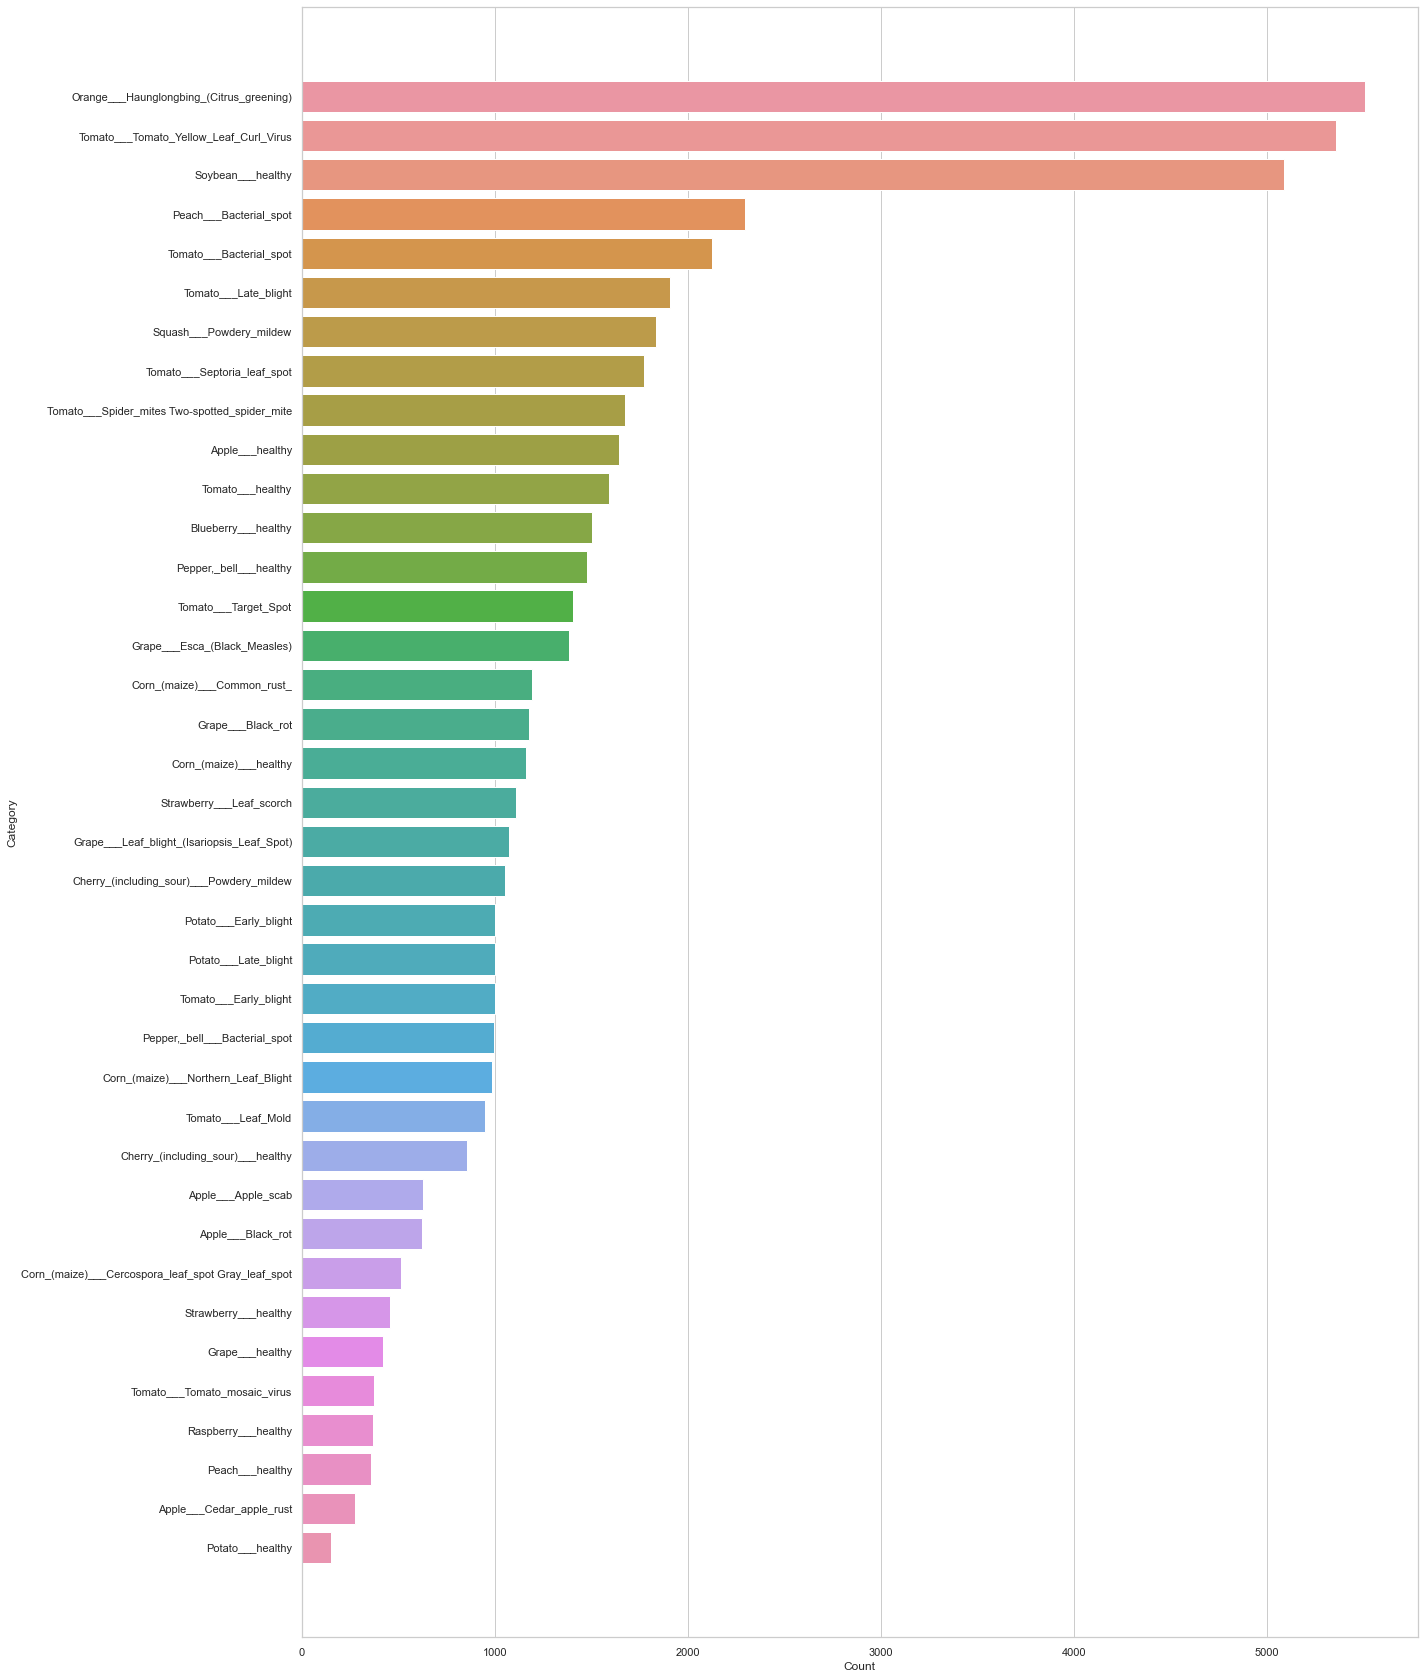

In [8]:
count_df = count_df.sort_values(by='Count', ascending=False)      # visualisation based on counts
plt.figure(figsize=(20,30))
sns.barplot(x="Count", y="Category", data=count_df)
plt.plot()

In [9]:
healthy_images_count = count_df[count_df['Category'].str.endswith("healthy")]['Count'].sum()  # separating infected and non infected images
print("healthy_images_count :", healthy_images_count ) 
disease_images_count = total_images - healthy_images_count
print("disease_images_count :", disease_images_count)

healthy_images_count : 15084
disease_images_count : 39221


[]

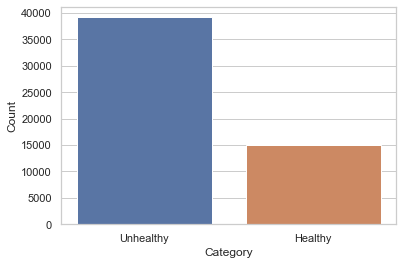

In [10]:
temp_df = pd.DataFrame(data=[("Unhealthy", disease_images_count), ("Healthy", healthy_images_count)], columns=['Category', 'Count'])
sns.barplot(y="Count",x="Category", data=temp_df)
plt.plot()   # plotting bar plot based on healthy and unhealthy images

In [11]:
healthy_cat = len(count_df[count_df['Category'].str.endswith('healthy')])
print("healthy_cat",healthy_cat)
print("unhealthy_cat",38 - healthy_cat)     # category count of images

healthy_cat 12
unhealthy_cat 26


In [12]:
path_data = []                                     # separating images into each respective category based on healthy and unhealthy

for root, dirs, files in os.walk("color"):
    for d in dirs:
        is_healthy = 1 if d.endswith("healthy") else 0
        leaf_type = d[:d.index("__")]
        
        parent = root+os.sep+d+os.sep
        
        for f in os.listdir(parent):
            path_data.append((leaf_type, is_healthy, d, parent+f))
            
path_df = pd.DataFrame(data=path_data, columns=['Leaf Type', 'Is Healthy', 'Category', 'Image Path'])
path_df

,Leaf Type,Is Healthy,Category,Image Path
0,Apple,0,Apple___Apple_scab,color\Apple___Apple_scab\00075aa8-d81a-4184-85...
1,Apple,0,Apple___Apple_scab,color\Apple___Apple_scab\01a66316-0e98-4d3b-a5...
2,Apple,0,Apple___Apple_scab,color\Apple___Apple_scab\01f3deaa-6143-4b6c-9c...
3,Apple,0,Apple___Apple_scab,color\Apple___Apple_scab\0208f4eb-45a4-4399-90...
4,Apple,0,Apple___Apple_scab,color\Apple___Apple_scab\023123cb-7b69-4c9f-a5...
...,...,...,...,...
54300,Tomato,0,Tomato___Tomato_Yellow_Leaf_Curl_Virus,color\Tomato___Tomato_Yellow_Leaf_Curl_Virus\f...
54301,Tomato,0,Tomato___Tomato_Yellow_Leaf_Curl_Virus,color\Tomato___Tomato_Yellow_Leaf_Curl_Virus\f...
54302,Tomato,0,Tomato___Tomato_Yellow_Leaf_Curl_Virus,color\Tomato___Tomato_Yellow_Leaf_Curl_Virus\f...
54303,Tomato,0,Tomato___Tomato_Yellow_Leaf_Curl_Virus,color\Tomato___Tomato_Yellow_Leaf_Curl_Virus\f...


In [13]:
max_samples_per_cat = 10000    # taking samples from each category in order to make balance dataset
replace = False

In [14]:
h_count = max_samples_per_cat // healthy_cat  
uh_count = max_samples_per_cat // (38 - healthy_cat)

new_data = []

for name, group in path_df.groupby(['Is Healthy', 'Category'], as_index=False):
    is_healthy, cat = name
    
    if is_healthy == 1:
        records = h_count
        
    else:
        records = uh_count
        
    #print(group[:records])
    for idx, row in group[:records].iterrows():
        new_data.append((is_healthy, cat, row['Image Path']))
        
new_df = pd.DataFrame(data=new_data, columns=['Is Healthy','Category', "Image Path"])
new_df           # creating  balanced dataset foer each category

,Is Healthy,Category,Image Path
0,0,Apple___Apple_scab,color\Apple___Apple_scab\00075aa8-d81a-4184-85...
1,0,Apple___Apple_scab,color\Apple___Apple_scab\01a66316-0e98-4d3b-a5...
2,0,Apple___Apple_scab,color\Apple___Apple_scab\01f3deaa-6143-4b6c-9c...
3,0,Apple___Apple_scab,color\Apple___Apple_scab\0208f4eb-45a4-4399-90...
4,0,Apple___Apple_scab,color\Apple___Apple_scab\023123cb-7b69-4c9f-a5...
...,...,...,...
17452,1,Tomato___healthy,color\Tomato___healthy\82a343d3-1a57-4190-b0d7...
17453,1,Tomato___healthy,color\Tomato___healthy\82a3d470-940b-431f-9d79...
17454,1,Tomato___healthy,color\Tomato___healthy\82b63dfc-d0b6-4bb3-afc4...
17455,1,Tomato___healthy,color\Tomato___healthy\82df832d-43d4-41c5-97b8...


In [15]:
len(new_df[new_df['Is Healthy'] == 1])

7593

In [16]:
len(new_df[new_df['Is Healthy'] == 0])

9864

In [17]:
def get_reshaped_image(img, new_shape=(128, 128)):
    resized_image = cv2.resize(img, new_shape, interpolation = cv2.INTER_NEAREST) 
    return resized_image

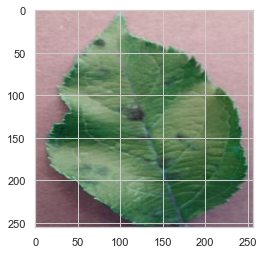

In [18]:
img = cv2.imread(new_df['Image Path'].iloc[0])
plt.imshow(img)

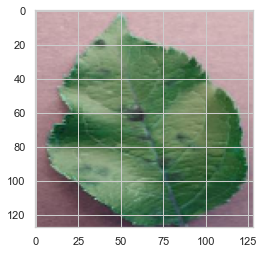

In [19]:
reshaped_img = get_reshaped_image(img)          # reshaping image
plt.imshow(reshaped_img)

In [20]:
def transform_data(df):             # transforming image data according to the cnn requirement
    features = []
    labels = []
   
    for i, row in df.iterrows():
        img_path = row['Image Path']
        cat = row['Is Healthy']

        try:
            img = cv2.imread(img_path)

            if img is None:
                continue
             
            resized_image = get_reshaped_image(img)

            features.append(resized_image)
            label = [0.0,0.0]
            label[cat] = 1.0
            labels.append(label)
            
            if i != 0 and i % 1000 == 0:
                print("Processed Images: ",i)
        except:
            print(f"Error in image: img_path={img_path}, cat={cat}")
            traceback.print_exc()
        
    return features, labels

    
features, labels = transform_data(new_df)
    
print(len(features))
print(len(labels))

features_2 = np.asarray(features)
print(features_2.shape)
labels_2 = np.asarray(labels)
print(labels_2.shape)

Processed Images:  1000
Processed Images:  2000
Processed Images:  3000
Processed Images:  4000
Processed Images:  5000
Processed Images:  6000
Processed Images:  7000
Processed Images:  8000
Processed Images:  9000
Processed Images:  10000
Processed Images:  11000
Processed Images:  12000
Processed Images:  13000
Processed Images:  14000
Processed Images:  15000
Processed Images:  16000
Processed Images:  17000
17457
17457
(17457, 128, 128, 3)
(17457, 2)


In [21]:
train_features, test_features, train_labels, test_labels = train_test_split(features_2, labels_2, test_size=0.2, random_state=42)
# splitting dataset into training and testing dataset

In [22]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(train_labels)

(13965, 128, 128, 3)
(3492, 128, 128, 3)
(13965, 2)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


### Intialising CNN model - Transfer Learning

### VGG-16 Model

In [23]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
input_shape=(128,128,3)
classes = 2
epoch = 3
batch_size = 16

vgg16 = VGG16(weights="imagenet", input_shape=input_shape, classes=classes, include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
    
x = Flatten()(vgg16.output)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model1 = Model(inputs=vgg16.input, outputs=prediction)

# summarize the model
model1.summary()

model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stop= EarlyStopping(monitor='val_loss',patience=10)

mcp_save = ModelCheckpoint('mdl_vgg16_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                        patience=10, 
                                        verbose=1, 
                                        factor=0.5, 
                                        min_lr=0.00001)

model1.fit(train_features, train_labels, 
          epochs=epoch, 
          batch_size=batch_size, 
          validation_data=(test_features,test_labels), 
          callbacks=[early_stop, learning_rate_reduction])
# callbacks=[early_stop, learning_rate_reduction]
# Save the model
filepath = 'model/vgg16_1'
save_model(model1, filepath)

metrics=pd.DataFrame(model1.history.history)
metrics

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

,loss,accuracy,val_loss,val_accuracy,lr
0,1.385274,0.911708,0.907861,0.943872,0.001
1,0.686118,0.955030,1.031969,0.948167,0.001
2,0.593698,0.965056,1.190737,0.949885,0.001


In [24]:
results = model1.evaluate(test_features,test_labels)
print(f"test acc = {results[1]}\ntest loss = {results[0]}")

110/110 [==============================] - 237s 2s/step - loss: 1.1907 - accuracy: 0.9499
test acc = 0.9498854279518127
test loss = 1.1907366514205933


In [25]:
y_pred1 = model1.predict(test_features)
y_pred1

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [2.9363116e-11, 1.0000000e+00],
       ...,
       [5.1204284e-04, 9.9948788e-01],
       [1.0000000e+00, 1.9822738e-18],
       [1.0000000e+00, 2.4667844e-16]], dtype=float32)

In [27]:
y_pred1= np.argmax(y_pred1, axis=1)
y_pred1

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [28]:
test_labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [29]:
test_labels__ = np.argmax(test_labels, axis=1)
test_labels__.shape

(3492,)

<Figure size 432x288 with 0 Axes>

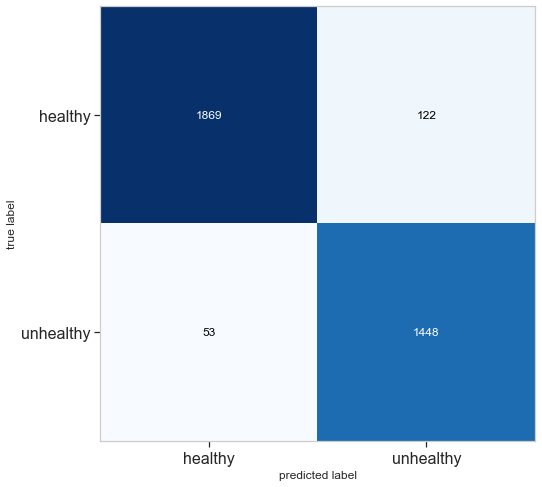

In [30]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm  = confusion_matrix(test_labels__, y_pred1)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['healthy', 'unhealthy'], fontsize=16)
plt.yticks(range(2), ['healthy', 'unhealthy'], fontsize=16)
plt.show()

In [31]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.96
Precision of the model is 0.92


In [32]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_labels__, y_pred1, target_names = ['Unhealthy (Class 0)','Healthy (Class 1)']))

                     precision    recall  f1-score   support

Unhealthy (Class 0)       0.97      0.94      0.96      1991
  Healthy (Class 1)       0.92      0.96      0.94      1501

           accuracy                           0.95      3492
          macro avg       0.95      0.95      0.95      3492
       weighted avg       0.95      0.95      0.95      3492



### ResNet-50 Model

In [33]:
from tensorflow.keras.applications.resnet50 import ResNet50
input_shape=(128,128,3)
classes = 2
epoch = 3
batch_size = 64

resnet50 = ResNet50(weights="imagenet", input_shape=input_shape, classes=classes,include_top=False)
for layer in resnet50.layers:
    layer.trainable = False
    
x = Flatten()(resnet50.output)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model2 = Model(inputs=resnet50.input, outputs=prediction)

# summarize the model
model2.summary()

model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stop= EarlyStopping(monitor='val_loss',patience=10)

mcp_save = ModelCheckpoint('mdl_resnt50_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model2.fit(train_features, train_labels,
          epochs=epoch,
          batch_size=batch_size,
          validation_data=(test_features,test_labels), 
          callbacks=[early_stop, learning_rate_reduction])
# callbacks=[early_stop, learning_rate_reduction]
# Save the model
filepath = 'model/resnt50'
save_model(model2, filepath)

metrics=pd.DataFrame(model2.history.history)
metrics

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/3
219/219 [==============================] - 490s 2s/step - loss: 0.3251 - accuracy: 0.9414 - val_loss: 0.1452 - val_accuracy: 0.9711
Epoch 2/3
219/219 [==============================] - 490s 2s/step - loss: 0.0856 - accuracy: 0.9794 - val_loss: 0.1185 - val_accuracy: 0.9742
Epoch 3/3
219/219 [==============================] - 496s 2s/step - loss: 0.0409 - accuracy: 0.9899 - val_loss: 0.1384 - val_accuracy: 0.9748
INFO:tensorflow:Assets written to: model/resnt50\assets


C:\Users\Abhishek\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


,loss,accuracy,val_loss,val_accuracy,lr
0,0.325076,0.941353,0.145160,0.971077,0.001
1,0.085563,0.979449,0.118537,0.974227,0.001
2,0.040924,0.989903,0.138377,0.974800,0.001


In [34]:
results = model2.evaluate(test_features,test_labels)
print(f"test acc = {results[1]}\ntest loss = {results[0]}")

110/110 [==============================] - 106s 960ms/step - loss: 0.1384 - accuracy: 0.9748
test acc = 0.9747995138168335
test loss = 0.1383773535490036


In [48]:
y_pred2 = model2.predict(test_features)
y_pred2

array([[1.0000000e+00, 2.7815215e-09],
       [1.0000000e+00, 1.0334976e-20],
       [1.3636815e-08, 1.0000000e+00],
       ...,
       [1.0000000e+00, 1.6528006e-09],
       [1.0000000e+00, 4.5371611e-13],
       [1.0000000e+00, 1.7561899e-26]], dtype=float32)

In [49]:
y_pred2= np.argmax(y_pred2, axis=1)
y_pred2

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

<Figure size 432x288 with 0 Axes>

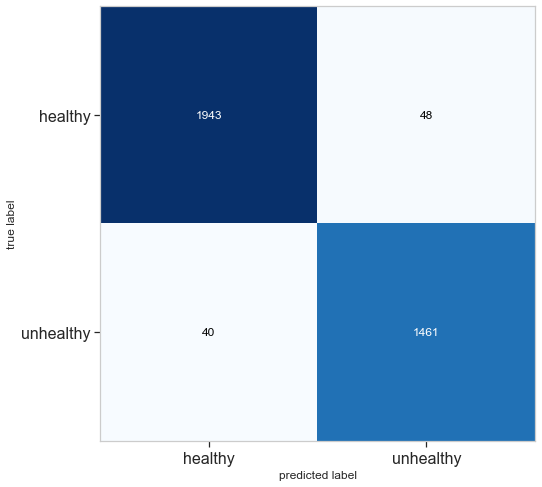

In [50]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm  = confusion_matrix(test_labels__, y_pred2)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['healthy', 'unhealthy'], fontsize=16)
plt.yticks(range(2), ['healthy', 'unhealthy'], fontsize=16)
plt.show()

In [51]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.97


In [52]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_labels__, y_pred2, target_names = ['Unhealthy (Class 0)','Healthy (Class 1)']))

                     precision    recall  f1-score   support

Unhealthy (Class 0)       0.98      0.98      0.98      1991
  Healthy (Class 1)       0.97      0.97      0.97      1501

           accuracy                           0.97      3492
          macro avg       0.97      0.97      0.97      3492
       weighted avg       0.97      0.97      0.97      3492



### Inception_V3 Model

In [41]:
input_shape=(128,128,3)
classes = 2
epoch = 3
batch_size = 64

inception_v3 = InceptionV3(weights="imagenet", input_shape=input_shape, classes=classes,include_top=False)
for layer in inception_v3.layers:
    layer.trainable = False
    
x = Flatten()(inception_v3.output)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model3 = Model(inputs=inception_v3.input, outputs=prediction)

model3.summary()

model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stop= EarlyStopping(monitor='val_loss',patience=10)

mcp_save = ModelCheckpoint('mdl_inception_v3_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model3.fit(train_features, train_labels,
          epochs=epoch,
          batch_size=batch_size,
          validation_data=(test_features,test_labels), 
          callbacks=[early_stop, learning_rate_reduction])
# callbacks=[early_stop, learning_rate_reduction]
# Save the model
filepath = 'model/inception_v3'
save_model(model3, filepath)

metrics=pd.DataFrame(model3.history.history)
metrics

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

219/219 [==============================] - 201s 896ms/step - loss: 9.0675 - accuracy: 0.6708 - val_loss: 9.4686 - val_accuracy: 0.6881
Epoch 2/3
219/219 [==============================] - 204s 932ms/step - loss: 4.9648 - accuracy: 0.7300 - val_loss: 6.5751 - val_accuracy: 0.6990
Epoch 3/3
219/219 [==============================] - 204s 934ms/step - loss: 4.8569 - accuracy: 0.7420 - val_loss: 3.4305 - val_accuracy: 0.7726
INFO:tensorflow:Assets written to: model/inception_v3\assets


,loss,accuracy,val_loss,val_accuracy,lr
0,9.067481,0.670820,9.468619,0.688144,0.001
1,4.964790,0.729968,6.575108,0.699026,0.001
2,4.856926,0.741998,3.430517,0.772623,0.001


In [42]:
results = model3.evaluate(test_features,test_labels)
print(f"test acc = {results[1]}\ntest loss = {results[0]}")

110/110 [==============================] - 44s 396ms/step - loss: 3.4305 - accuracy: 0.7726
test acc = 0.7726231217384338
test loss = 3.430516242980957


In [53]:
y_pred3 = model3.predict(test_features)
y_pred3

array([[1.0000000e+00, 3.1158730e-14],
       [1.0000000e+00, 2.6307336e-14],
       [7.1472279e-11, 1.0000000e+00],
       ...,
       [3.3350405e-01, 6.6649598e-01],
       [1.0546547e-05, 9.9998951e-01],
       [1.0000000e+00, 2.9878001e-12]], dtype=float32)

In [54]:
y_pred3= np.argmax(y_pred3, axis=1)
y_pred3

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

<Figure size 432x288 with 0 Axes>

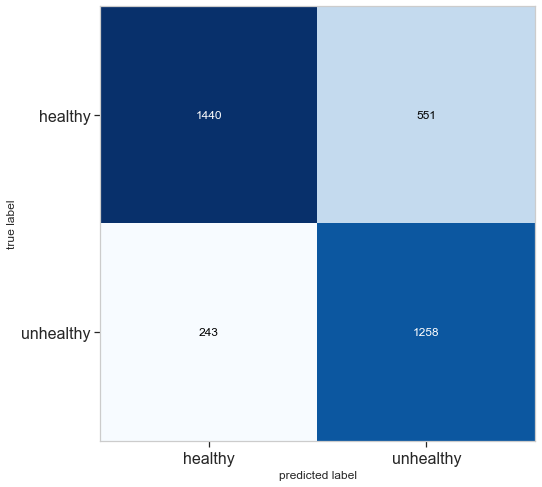

In [55]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm  = confusion_matrix(test_labels__, y_pred3)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['healthy', 'unhealthy'], fontsize=16)
plt.yticks(range(2), ['healthy', 'unhealthy'], fontsize=16)
plt.show()

In [56]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.84
Precision of the model is 0.70


In [57]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_labels__, y_pred3, target_names = ['Unhealthy (Class 0)','Healthy (Class 1)']))

                     precision    recall  f1-score   support

Unhealthy (Class 0)       0.86      0.72      0.78      1991
  Healthy (Class 1)       0.70      0.84      0.76      1501

           accuracy                           0.77      3492
          macro avg       0.78      0.78      0.77      3492
       weighted avg       0.79      0.77      0.77      3492

